In [31]:

import sys
from pathlib import Path

# Get the path of the current notebook
notebook_path = Path().resolve()

# Get the project root directory (one level up from the notebook's directory)
project_root = notebook_path.parent

# Add the project root to the Python path
sys.path.append(str(project_root))

from config import DB_HOST, DB_PORT, DB_NAME, DB_USER, DB_PASSWORD # Import credentials
from src.db_client import DatabaseClient

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg.sql as sql #dynamically select column names in SQL queries with psycopg (and avoid SQL injection vulnerabilities)
import pycountry
import matplotlib.cm as cm
import cartopy.crs as ccrs #cordinate reference systeme
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.colors as mcolors
from src.utils import high_contrast_color
from datetime import datetime

In [9]:
# --- Database Client Initialization (Global for this script) ---
# This client will be passed to functions that need to interact with the DB.
db_client = DatabaseClient(
    host=DB_HOST,
    port=DB_PORT,
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD
)

In [10]:

# SQL query to select all data from the 'spotify_songs_2024' table.
# This query is used to retrieve the entire dataset without any filters
# for comprehensive analysis or initial data loading.

num_parameters_query = """
SELECT*
FROM
    spotify_songs_2024
"""

In [11]:
#read the data from the database using the DatabaseClient instance
# This method fetches the data from the database using the provided SQL query.

df = db_client.get_data(num_parameters_query)

Executing query:

SELECT*
FROM
    spotify_songs_2024

Fetched 1282224 rows.
Database connection closed.


In [18]:
#Correlation matrix calculation and heatmap parameters.


# List of non-numeric columns from the spotify_songs_2024 table.
# These columns are typically used for filtering or as categorical variables,
# but are not suitable for direct correlation analysis.
no_num_col = [
    "id", "spotify_id", "name", "artists", "daily_movement", "weekly_movement",
    "country", "snapshot_date", "album_name", "album_release_date"
]

# List of numeric columns from the spotify_songs_2024 table.
# These columns contain numerical data and are suitable for statistical
# analysis, such as calculating correlation.
num_cols = [
    "daily_rank", "popularity", "is_explicit", "duration_ms", "danceability",
    "energy", "key", "loudness", "mode", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "time_signature"
]

# List of numeric columns selected for correlation analysis.
# This list is used to specify which columns will be included in the
# correlation matrix calculation.
col_2_corr = [
    "daily_rank", "popularity", "is_explicit", "duration_ms", "danceability",
    "energy", "key", "loudness", "mode", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "time_signature"
]

# A dictionary to specify row-level filters for the DataFrame.
# The keys are column names and the values are the desired values to filter by.
# If this dictionary is empty, no row filtering will be applied.
#
# Examples of usage:
# - To filter for a specific country:
#   row_filters = {"country": "PA"}
# - To filter for non-explicit songs (is_explicit is a boolean/numeric flag):
#   row_filters = {"country": "CA", "is_explicit": 0}
#
# An empty dictionary mesnd that no filters will be applied.
row_filters = {"country": "US"}

In [19]:
#Retrieves and filters data from the database, then calculates the correlation matrix.

df = db_client.get_data(num_parameters_query)

if row_filters:
    mask = pd.Series([True] * len(df))
    for col, val in row_filters.items():
        if col in df.columns:
            mask &= df[col] == val
        else:
            print(f"Warning: Column '{col}' does not exist. Skipping filter.")
    df_rows_filtered = df[mask].copy()
else:
    df_rows_filtered = df

if all(elem in num_cols for elem in col_2_corr):
    df_final = df_rows_filtered.loc[:, col_2_corr].copy()
    corr_matrix = df_final.corr()
    print("Correlation Matrix successfully calculated:")
    print(corr_matrix)
else:
    print(f"Error: At least one column in {col_2_corr} is not numeric or does not exist.")



Executing query:

SELECT*
FROM
    spotify_songs_2024

Fetched 1282224 rows.
Database connection closed.
Correlation Matrix successfully calculated:
                  daily_rank  popularity  is_explicit  duration_ms  \
daily_rank          1.000000   -0.121436     0.018056    -0.107305   
popularity         -0.121436    1.000000    -0.051246    -0.005135   
is_explicit         0.018056   -0.051246     1.000000     0.028032   
duration_ms        -0.107305   -0.005135     0.028032     1.000000   
danceability       -0.071848    0.038339     0.355351    -0.118666   
energy             -0.063858    0.018006     0.210834    -0.096567   
key                 0.042244    0.033011    -0.146917    -0.058940   
loudness           -0.090979    0.044420     0.186120    -0.073834   
mode               -0.047305   -0.016989    -0.044260    -0.010447   
speechiness         0.037573   -0.115035     0.351836     0.092199   
acousticness        0.138537   -0.072276    -0.203283    -0.057237   
instrumenta

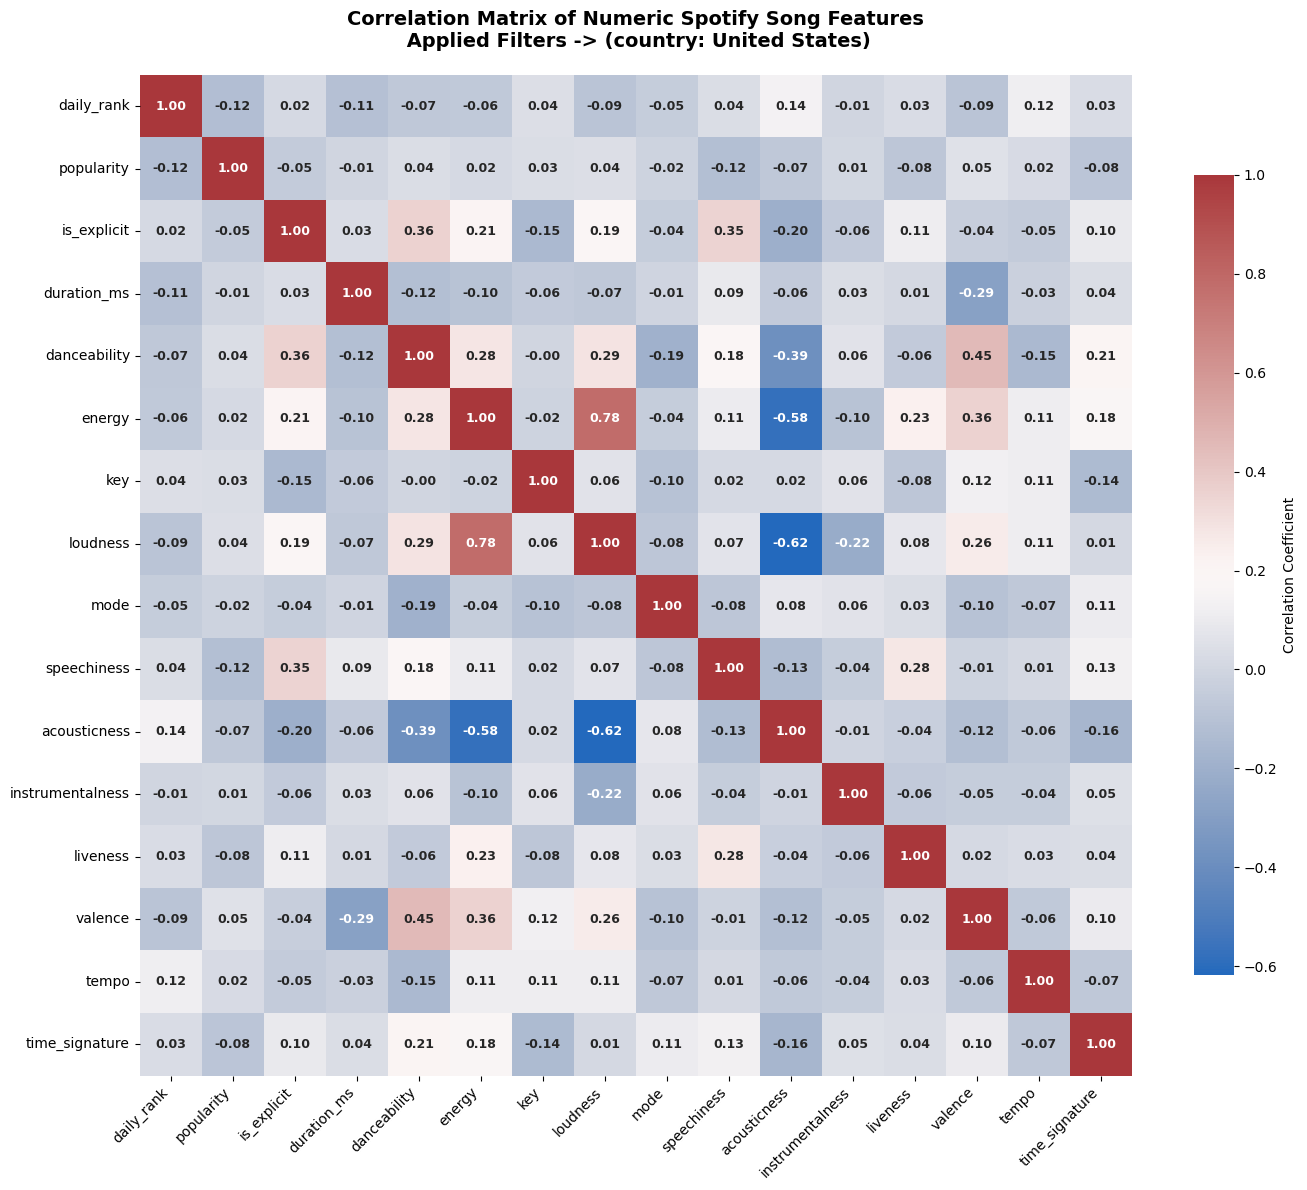

In [20]:
#Plotting the correlation matrix using seaborn and matplotlib.


plt.figure(figsize=(14, 12))

sns.heatmap(
    corr_matrix, 
    annot=True,  # Display correlation values on the heatmap.
    cmap='vlag',  
    fmt=".2f",  # Format annotations to two decimal places.
    #linewidths=.5,  # Add lines between cells.
    linecolor='gray', 
    cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.8},  # Customize color bar.
    annot_kws={"fontsize": 9, "weight": "bold"} 
)

# Dynamically set the plot title based on applied filters.
if row_filters:
    # Convert country code to full name if present in filters.
    if "country" in row_filters:
        if row_filters["country"] == "ZZ":
            row_filters["country"] = "Global"
        else:
            country = pycountry.countries.get(alpha_2=row_filters["country"])
            if country:
                row_filters["country"] = country.name

    # Construct the subtitle from applied filters.
    plain_text = ' | '.join(f"{key}: {value}" for key, value in row_filters.items())
    plt.title(
        f'Correlation Matrix of Numeric Spotify Song Features\n Applied Filters -> ({plain_text})',
        fontsize=14, pad=20, weight='bold'
    )
else:
    # Set a generic title if no filters are applied.
    plt.title(
        "Correlation Matrix of Numeric Spotify Song Features",
        fontsize=14, pad=20, weight='bold'
    )

# Adjust x and y axis tick label properties.
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Remove the top, right, bottom, and left spines (borders) for a cleaner look.
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Adjust plot layout to prevent labels/titles from overlapping.
plt.tight_layout()
plt.savefig(f"../output/correlation_matrix_{row_filters["country"]}.png", dpi=300, bbox_inches='tight')

# Display the plot.
plt.show()

In [22]:
# Function to generate a SQL query for calculating the correlation
# between a specified feature and the target column (popularity) by month.

query = """
WITH by_month AS (
    SELECT
        EXTRACT(MONTH FROM snapshot_date) AS month,
        TO_CHAR(snapshot_date, 'Mon') AS month_name,
        {feature_col} AS feature_col,
        {target_col} AS target_col
    FROM
        spotify_songs_2024
    WHERE
        snapshot_date IS NOT NULL
        AND danceability IS NOT NULL
        AND popularity IS NOT NULL
        AND country = %s
)
SELECT
    month,
    month_name,
    CORR(feature_col, target_col) AS correlation
FROM
    by_month
GROUP BY
    month,
    month_name
ORDER BY
    month;
"""

In [45]:
#Monthly correlation analysis parameters.

# A list of numeric features to be correlated against the target column.
# These columns are typically used to find relationships with a primary variable.
features_to_correlate = [
    'danceability', 'speechiness', 'liveness',
    'energy', 'valence', 'tempo', 'time_signature',
    'key', 'instrumentalness', 'mode', 'is_explicit',
    'acousticness', 'loudness'
]

# The target column for correlation analysis.
# All features in -> features_to_correlate <- will be measured against this column.
target_col = 'popularity'

# The correlation threshold used to filter results.
# Correlations with an absolute value less than this threshold might be
# considered weak or insignificant and can be filtered out for display.
# (e.g., a value of 0.3 means only correlations stronger than ±0.3 are considered).
correlation_threshold = 0.2

# A list of ISO 3166-1 alpha-2 country codes to filter the data by.
# A value of "ZZ" is used to represent the global.
target_country_values = ['US']

"""target_country_values = [
    "AE", "AR", "AT", "AU", "BE", "BG", "BO", "BR", "BY", "CA", "CH", "CL", "CO", "CR", "CZ", "DE",
    "DK", "DO", "EC", "EE", "EG", "ES", "FI", "FR", "GB", "GR", "GT", "HK", "HN", "HU", "ID", "IE",
    "IL", "IN", "IS", "IT", "JP", "KR", "KZ", "LT", "LU", "LV", "MA", "MX", "MY", "NG", "NI", "NL",
    "NO", "NZ", "PA", "PE", "PH", "PK", "PL", "PT", "PY", "RO", "SA", "SE", "SG", "SK", "SV", "TH",
    "TR", "TW", "UA", "US", "UY", "VE", "VN", "ZA", "ZZ"
]"""

# The following provides a general interpretation of correlation strength:
# Very Strong: ±0.70 to ±1.00
# Strong: ±0.50 to ±0.69
# Moderate: ±0.30 to ±0.49
# Weak: ±0.10 to ±0.29
# Very Weak: 0.00 to ±0.09


'target_country_values = [\n    "AE", "AR", "AT", "AU", "BE", "BG", "BO", "BR", "BY", "CA", "CH", "CL", "CO", "CR", "CZ", "DE",\n    "DK", "DO", "EC", "EE", "EG", "ES", "FI", "FR", "GB", "GR", "GT", "HK", "HN", "HU", "ID", "IE",\n    "IL", "IN", "IS", "IT", "JP", "KR", "KZ", "LT", "LU", "LV", "MA", "MX", "MY", "NG", "NI", "NL",\n    "NO", "NZ", "PA", "PE", "PH", "PK", "PL", "PT", "PY", "RO", "SA", "SE", "SG", "SK", "SV", "TH",\n    "TR", "TW", "UA", "US", "UY", "VE", "VN", "ZA", "ZZ"\n]'

Executing query:
Composed([SQL("\nWITH by_month AS (\n    SELECT\n        EXTRACT(MONTH FROM snapshot_date) AS month,\n        TO_CHAR(snapshot_date, 'Mon') AS month_name,\n        "), Identifier('danceability'), SQL(' AS feature_col,\n        '), Identifier('popularity'), SQL(' AS target_col\n    FROM\n        spotify_songs_2024\n    WHERE\n        snapshot_date IS NOT NULL\n        AND danceability IS NOT NULL\n        AND popularity IS NOT NULL\n        AND country = %s\n)\nSELECT\n    month,\n    month_name,\n    CORR(feature_col, target_col) AS correlation\nFROM\n    by_month\nGROUP BY\n    month,\n    month_name\nORDER BY\n    month;\n')])
Fetched 12 rows.
Database connection closed.
danceability is not betwen -0.2 and 0.2
Executing query:
Composed([SQL("\nWITH by_month AS (\n    SELECT\n        EXTRACT(MONTH FROM snapshot_date) AS month,\n        TO_CHAR(snapshot_date, 'Mon') AS month_name,\n        "), Identifier('speechiness'), SQL(' AS feature_col,\n        '), Identifier('po

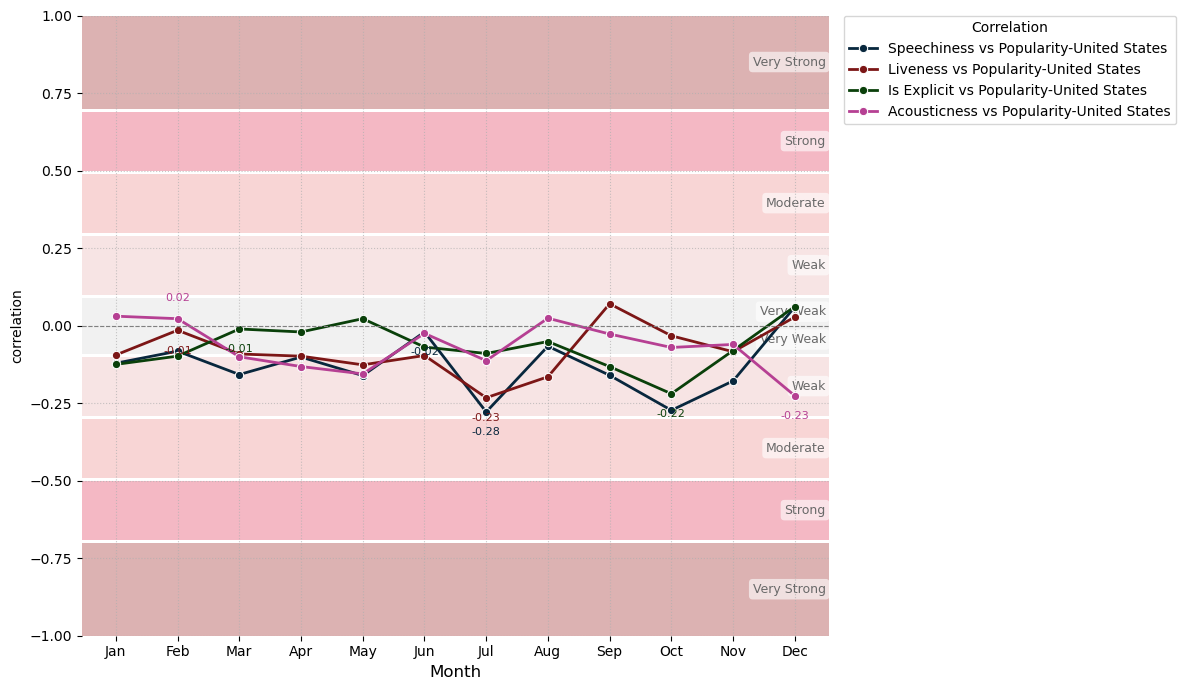

In [46]:
#Plot the correlation results using seaborn and matplotlib in a line plot. 
#This is done line by line for each feature against the target column for an specific country.

plt.figure(figsize=(12, 7))
sns.set_palette("tab20") 
plot_any = False #in case the correlation thresholg id tw high and any figure is drawn

text_separation = 0.05
show_min = True # shows the minumum value in for correlation in all the year
show_max = True # shows the maximum value in for correlation in all the year


# Determine the total number of unique lines to plot
num_lines = len(features_to_correlate) * len(target_country_values)

#Persoonalize the colors for each line in the plot.
colors = [
    "#08273d",  # deep navy blue
    "#7c1616",  # strong red
    "#0a400a",  # dark green
    "#b64093",  # vibrant magenta
    "#696900",  # dark olive
    "#17becf",  # cyan
    "#ff9896",  # light red
    "#393b79",  # navy purple
    "#ad494a",  # brick red
    "#4a668a",  # steel blue
    "#c49c94",  # warm beige
    "#98df8a",  # soft green
    "#843c39",  # earthy red
    "#9edae5",  # pastel teal
    "#a55194",  # purple
    "#658119",  # olive green
    "#9a6735",  # light orange
    "#c7c7c7",  # neutral gray
    "#743e0e",  # brown
    "#535336",  # light yellow
]

color_idx = 0

# --- Define Correlation Ranges for Visualization ---
correlation_ranges = [
    {
        'label': 'Very Weak',
        'min': 0.00,
        'max': 0.09,
        'pos_color': '#D3D3D3',   # light gray
        'neg_color': '#D3D3D3'
    },
    {
        'label': 'Weak',
        'min': 0.10,
        'max': 0.29,
        'pos_color': '#E6A8A8',   # light red-gray
        'neg_color': '#E6A8A8'
    },
    {
        'label': 'Moderate',
        'min': 0.30,
        'max': 0.49,
        'pos_color': '#E97474',   # soft red
        'neg_color': '#E97474'
    },
    {
        'label': 'Strong',
        'min': 0.50,
        'max': 0.69,
        'pos_color': '#DC143C',   # crimson
        'neg_color': '#DC143C'
    },
    {
        'label': 'Very Strong',
        'min': 0.70,
        'max': 1.00,
        'pos_color': '#8B0000',   # dark red
        'neg_color': '#8B0000'
    }
]



# Get the current axes object for plotting ranges
ax = plt.gca()

# So, 11.5 places the text just past the last month tick.
x_text_position = 11.5

# Plot shaded regions for correlation ranges
for r in reversed(correlation_ranges):
    ax.axhspan(r['min'], r['max'], facecolor=r['pos_color'], alpha=0.3, zorder=0)
    ax.axhspan(-r['max'], -r['min'], facecolor=r['neg_color'], alpha=0.3, zorder=0)
    
    ax.text(
        x=x_text_position,
        y=(r['min'] + r['max']) / 2,
        s=r['label'],
        ha='right', va='center', fontsize=9, color='dimgray',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.6),
        zorder=1
    )
    ax.text(
        x=x_text_position,
        y=-(r['min'] + r['max']) / 2,
        s=r['label'],
        ha='right', va='center', fontsize=9, color='dimgray',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.6),
        zorder=1
    )

# Iterate over each target country value and feature to correlate
# to generate the correlation plots.

for target_country_value in target_country_values:
    
    for feature_to_correlate in features_to_correlate:

        
        current_line_color = colors[color_idx % len(colors)] #% don't allow to select an indice bigger than 19, 20%20 =0, 

        composed_query = sql.SQL(query).format(
            feature_col=sql.Identifier(feature_to_correlate),
            target_col=sql.Identifier(target_col)
        )

        df = db_client.get_data(composed_query,(target_country_value,))
        monthly_correlations = df.copy()
        
        if (abs(monthly_correlations['correlation']) >= correlation_threshold).any():
            
            color_idx += 1
            sns.lineplot(
                data=monthly_correlations,
                x='month_name', # Use month names for x-axis labels
                y='correlation',
                marker='o',
                color=current_line_color,
                linewidth=2,
                label=f"{feature_to_correlate.replace('_', ' ').title()} vs {target_col.title()}-{pycountry.countries.get(alpha_2=target_country_value).name if pycountry.countries.get(alpha_2=target_country_value) else "Global" }"  
                )
            
            if show_min:
                # Calculate absolute correlations ( returna pandas series)
                abs_correlations = abs(monthly_correlations['correlation'])
                
                # Find index of correlation closest to zero and use .loc(to extract values)
                idx_closest_to_zero = abs_correlations.idxmin()
                corr_closest_to_zero = monthly_correlations.loc[idx_closest_to_zero, 'correlation']
                month_closest_to_zero = monthly_correlations.loc[idx_closest_to_zero, 'month_name']

                # Annotate point closest to zero
                plt.annotate(
                    f'{corr_closest_to_zero:.2f}', # Format to 2 decimal places
                    xy=(month_closest_to_zero, corr_closest_to_zero),
                    xytext=(month_closest_to_zero, corr_closest_to_zero + text_separation if corr_closest_to_zero >= 0 else corr_closest_to_zero - text_separation),
                    textcoords='data',
                    arrowprops=None, # Removed the arrow
                    horizontalalignment='center',
                    verticalalignment='bottom' if corr_closest_to_zero >= 0 else 'top',
                    fontsize=8,
                    color=current_line_color # Set annotation color to match line color
                    )
            
            if show_max:
                # Calculate absolute correlations ( returns a pandas series)
                abs_correlations = abs(monthly_correlations['correlation'])

                # Find index of correlation farthest from zero and use .loc(to extract values)
                idx_farthest_from_zero = abs_correlations.idxmax()
                corr_farthest_from_zero = monthly_correlations.loc[idx_farthest_from_zero, 'correlation']
                month_farthest_from_zero = monthly_correlations.loc[idx_farthest_from_zero, 'month_name']
            
                # Annotate point farthest from zero
                plt.annotate(
                    f'{corr_farthest_from_zero:.2f}', # Format to 2 decimal places
                    xy=(month_farthest_from_zero, corr_farthest_from_zero),
                    xytext=(month_farthest_from_zero, corr_farthest_from_zero + text_separation if corr_farthest_from_zero >= 0 else corr_farthest_from_zero - text_separation),
                    textcoords='data',
                    arrowprops=None, 
                    horizontalalignment='center',
                    verticalalignment='bottom' if corr_farthest_from_zero >= 0 else 'top',
                    fontsize=8,
                    color=current_line_color # Set annotation color to match line color
                    )
                

            plot_any = True 
        else:
            print(f"{feature_to_correlate} is not betwen -{correlation_threshold} and {correlation_threshold}")
if plot_any:

     # Add a horizontal line at y=0 for easy reference (no correlation)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.xlabel('Month', fontsize=12)
    # Dynamically set the Y-axis label based on the feature
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.ylim(-1, 1) # Ensure y-axis covers the full correlation range

    ax = plt.gca()
    # Remove all four spines (the "box" and the x/y axis lines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False) # Remove x-axis line
    ax.spines['left'].set_visible(False) 
        
    plt.legend(title='Correlation', bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1, borderaxespad=0.)
    plt.tight_layout() # Adjust layout to prevent labels/legend from overlapping
    plt.savefig("../output/correlation_US_0.2.png", dpi=300, bbox_inches='tight')
    plt.show() #
else:
    plt.figure(figsize=(12, 7))
    plt.plot([0], [0], alpha=0)  # Invisible point just to create a figure
    plt.text(0, 0, 'No data to plot', ha='center', va='center', fontsize=14)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axis('off')  # Hide axes
    plt.show()
    


In [47]:
# SQL query to calculate the average popularity of explicit songs by country.
#the average of other than popularity can be modified by changing the column name in the query.

explicit_popularity_query = """
WITH song_average_popularity_per_country AS (
    SELECT
        country,
        spotify_id, 
        AVG(popularity) AS song_avg_popularity 
    FROM
        spotify_songs_2024
    WHERE
        is_explicit = 1
        AND country <> 'ZZ'
    GROUP BY
        country,
        spotify_id
)
SELECT
    country,
    AVG(song_avg_popularity) AS avg_explicit_popularity
FROM
    song_average_popularity_per_country
GROUP BY
    country
ORDER BY
    avg_explicit_popularity DESC;
"""

Executing query:

WITH song_average_popularity_per_country AS (
    SELECT
        country,
        spotify_id, 
        AVG(popularity) AS song_avg_popularity 
    FROM
        spotify_songs_2024
    WHERE
        is_explicit = 1
        AND country <> 'ZZ'
    GROUP BY
        country,
        spotify_id
)
SELECT
    country,
    AVG(song_avg_popularity) AS avg_explicit_popularity
FROM
    song_average_popularity_per_country
GROUP BY
    country
ORDER BY
    avg_explicit_popularity DESC;

Fetched 72 rows.
Database connection closed.

Successfully fetched 72 rows for explicit song popularity by country (refined).

Explicit Song Popularity Data Preview (first 10 rows - Refined):
  country  avg_explicit_popularity
0      ID      88.9106224758123467
1      MY      82.5874781351912788
2      SG  80.77303031798438173654
3      BO  79.97137397790500237746
4      TW      79.9036286987325361
5      PY      79.2995202837307709
6      PE  78.27065230377043607857
7      HK  78.239310298768522860

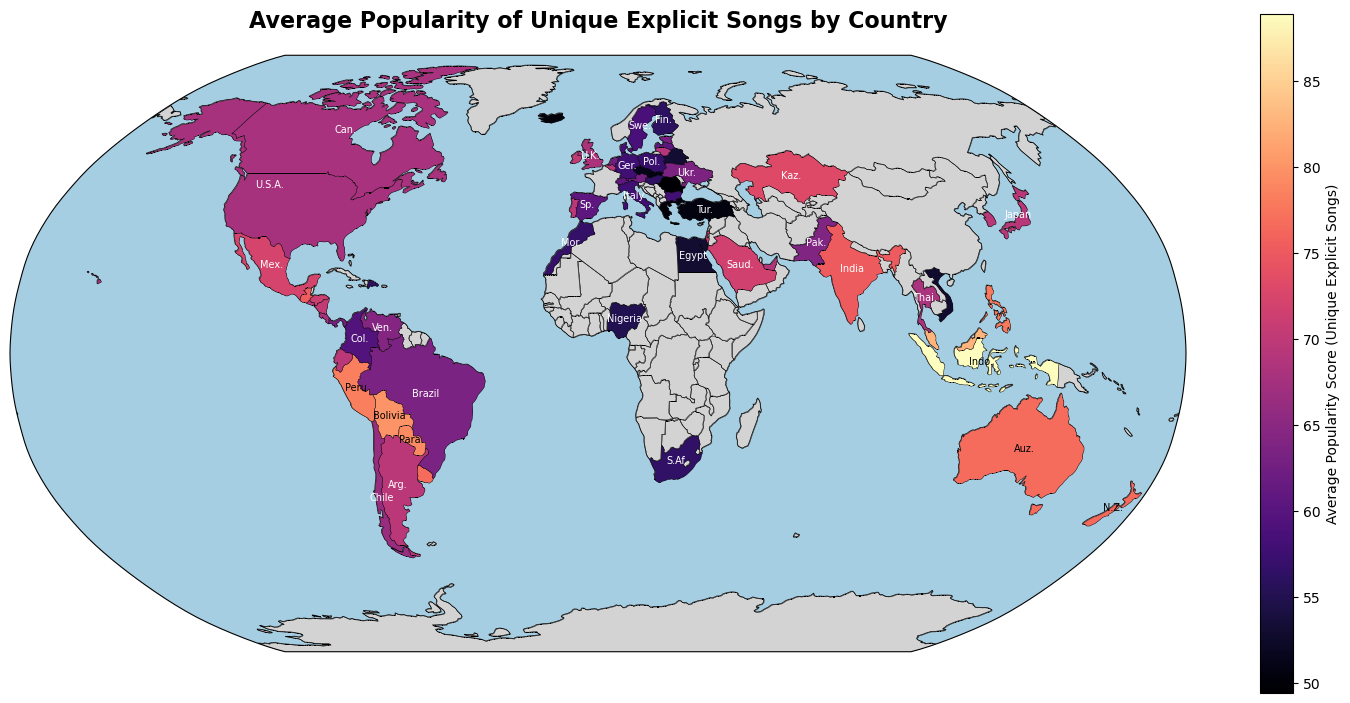

In [50]:
#Plotting the average popularity of explicit songs by country on a world map using Cartopy.


# Use the get_data_from_db function to fetch the data into a Pandas DataFrame
try:
    df_explicit_popularity = db_client.get_data(explicit_popularity_query)
except Exception as e:
    print(f"ERROR: Could not fetch data for explicit song popularity by country. Details: {e}")
    df_explicit_popularity = pd.DataFrame() # Ensure an empty DataFrame if an error occurs

# 3. Data preparation: Prepare data for mapping
if not df_explicit_popularity.empty:
    print(f"\nSuccessfully fetched {len(df_explicit_popularity)} rows for explicit song popularity by country (refined).")
    print("\nExplicit Song Popularity Data Preview (first 10 rows - Refined):")
    print(df_explicit_popularity.head(10))

    # Convert country codes to full names for potential use (though not directly used for map coloring)
    df_explicit_popularity['country_name'] = df_explicit_popularity['country'].apply(
        lambda x: pycountry.countries.get(alpha_2=x).name if pycountry.countries.get(alpha_2=x) else x
    )

    # Convert popularity to a format suitable for color mapping
    # Normalize popularity values to a 0-1 range for colormap
    min_pop = df_explicit_popularity['avg_explicit_popularity'].min()
    max_pop = df_explicit_popularity['avg_explicit_popularity'].max()
    # Avoid division by zero if all popularities are the same
    if max_pop == min_pop:
        df_explicit_popularity['normalized_popularity'] = 0.5
    else:
        df_explicit_popularity['normalized_popularity'] = (df_explicit_popularity['avg_explicit_popularity'] - min_pop) / (max_pop - min_pop)

    # Define a colormap this object contains all the information about 
    # the color gradient, how colors transition, and how to map numerical
    #  values to those colors.
    cmap = cm.magma #  other sequential colormaps are 'plasma', 'magma', 'cividis'

    # 4. Create the world map using Cartopy 
    plt.figure(figsize=(15, 10)) # Set the figure size for the map
    ax = plt.axes(projection=ccrs.Robinson()) # Use PlateCarree projection for a simple rectangular map
    #ccrs.PlateCarree() returns a Cartopy projection object. ccrs.Robinson() ccrs.Mercator() ccrs.Mollweide()

    # Add standard map features
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='#a6cee3') #'#1f78b4''#a6cee3', '#66c2a5'
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.3)
    #ax.add_feature(cfeature.LAKES, facecolor='lightblue')
    #ax.add_feature(cfeature.RIVERS, edgecolor='lightblue')

    # Set the extent of the map (optional, but good for focus)
    # ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree()) # Global view

    # --- START OF REPLACED/UPDATED CODE FOR PLOTTING COUNTRIES ---
    # Load shapefile path using shpreader
    shp_path = shpreader.natural_earth(
        resolution="110m",
        category="cultural",
        name="admin_0_countries"
    )

    reader = shpreader.Reader(shp_path)
    records = list(reader.records()) # Get a list of all country records
    #Each "record" represents a single geographical feature 
    # (in this case, a country). each record contains
    #  both the geometry (the shape of the country, like a polygon) 
    # and its attributes (country's name, ISO codes, population, etc.).

    # Plot each country
    for rec in records:
        iso = rec.attributes.get("ISO_A2") # Access ISO_A2 from attributes
        geom = rec.geometry # Get the geometry of the country

        if iso in df_explicit_popularity["country"].array:
            # If we have data for this country, color it based on popularity
            norm_val = float(df_explicit_popularity.loc[ #label-based indexer keeps only the rows where the corresponding value in the boolean mask is True
                df_explicit_popularity["country"] == iso,
                "normalized_popularity"
            ].values[0]) 
            face = cmap(norm_val) # Get color from colormap
            z = 2 # Higher zorder to be on top

            # Get the country name for the label
            country_name_for_label = rec.attributes.get("ABBREV")
            if not country_name_for_label: # If ABBREV is None or empty
                country_name_for_label = rec.attributes.get("NAME")

            # Try to get a centroid for text placement
            try:
                # Use the centroid of the geometry for text placement
                lon_text = geom.centroid.x
                lat_text = geom.centroid.y
                # Add country name as text label
                if geom.area > 30:
                    ax.text(
                        lon_text, lat_text,
                        country_name_for_label,
                        transform=ccrs.PlateCarree(), # Text coordinates are in PlateCarree
                        fontsize=7,
                        ha='center', va='center',
                        color=high_contrast_color(face), # You can adjust text color for readability
                        zorder=3 # Ensure text is above the colored country
                    )
            except Exception as e:
                print(f"Could not place text for {country_name_for_label} ({iso}): {e}")
                # Fallback or skip if centroid is problematic (e.g., for multi-part geometries spread out)

        else:
            # If no data, color it lightgray
            face = "lightgray"
            z = 1 # Lower zorder to be behind colored countries

        ax.add_geometries(
            [geom],
            ccrs.PlateCarree(), #
            facecolor=face,
            edgecolor="black",
            linewidth=0.3,
            zorder=z
        )
    # --- END OF REPLACED/UPDATED CODE FOR PLOTTING COUNTRIES ---

    # Add a colorbar to explain the popularity scale
    sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_pop, vmax=max_pop))
    sm.set_array([]) # Empty array for scalarmappable
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
    cbar.set_label('Average Popularity Score (Unique Explicit Songs)', fontsize=10)

    # Set title
    plt.title('Average Popularity of Unique Explicit Songs by Country', fontsize=16, weight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('../output/world_map_explicit_popularity.png', format='png', bbox_inches='tight', dpi=300)
    plt.show()
    